In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dash import Dash, dcc, html
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
import plotly.express as px
from prophet import Prophet
import logging

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Dash version:", dash.__version__)
#print("Plotly version:", go.__version__)
#print("Prophet version:", Prophet.__version__)


Pandas version: 1.5.3
NumPy version: 1.24.4
Matplotlib version: 3.9.0
Seaborn version: 0.12.2
Dash version: 2.17.1


In [2]:
q1_2023 = pd.read_csv("appointment_data_Q1_2023.csv")
q2_2023 = pd.read_csv("appointment_data_Q2_2023.csv")
q3_2023 = pd.read_csv("appointment_data_Q3_2023.csv")
q4_2023 = pd.read_csv("appointment_data_Q4_2023.csv")
q1_2024 = pd.read_csv("appointment_data_Q1_2024.csv")

In [3]:
print(q1_2023.shape[0])
print(q2_2023.shape[0])
print(q3_2023.shape[0])
print(q4_2023.shape[0])
print(q1_2024.shape[0])

2090
2158
2148
2151
2107


In [4]:
# Seaborn palette
sns_palette = sns.cubehelix_palette(n_colors=6, light=0.7, dark=0.3).as_hex()

# Apply Seaborn palette to Plotly Express
px.defaults.color_discrete_sequence = sns_palette

# Define layout theme
default_layout = go.Layout(
    template='plotly_white', 
    font=dict(family="Arial", size=14, color="#7f7f7f"),
    title_font=dict(size=18, family='Arial, sans-serif', color='#4d4d4d'),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    margin=dict(l=20, r=20, t=40, b=20),
    hovermode="closest"
)

In [5]:
# Function to apply the theme to all figures
def update_figure_layout(fig):
    fig.update_layout(default_layout)
    return fig

In [6]:
# 2023
appointment_data_2023 = pd.concat([q1_2023, q2_2023, q3_2023, q4_2023])

# (No_Show == 1)
total_no_show_charges_2023 = appointment_data_2023[appointment_data_2023['No_Show'] == 1]['Patient_Charges'].sum()

# (No_Show == 0)
total_attended_charges_2023 = appointment_data_2023[appointment_data_2023['No_Show'] == 0]['Patient_Charges'].sum()

print(f"Total Charges from No-Shows in 2023: ${total_no_show_charges_2023:,.2f}")
print(f"Total Charges from Attended Appointments in 2023: ${total_attended_charges_2023:,.2f}")

Total Charges from No-Shows in 2023: $80,450.00
Total Charges from Attended Appointments in 2023: $1,561,050.00


In [7]:
# fixed costs per quarter
rent_per_quarter = 9387
utilities_per_quarter = 813
staff_salaries_per_quarter = 61300

# Function to calculate variable costs (avg $42 per attended appointment)
def calculate_variable_costs(appointments_attended, cost_per_appointment=42):
    return appointments_attended * cost_per_appointment

# attended appointments for each quarter
attended_q1 = q1_2023[q1_2023['No_Show'] == 0].shape[0]
attended_q2 = q2_2023[q2_2023['No_Show'] == 0].shape[0]
attended_q3 = q3_2023[q3_2023['No_Show'] == 0].shape[0]
attended_q4 = q4_2023[q4_2023['No_Show'] == 0].shape[0]

# variable costs for each quarter
variable_costs_q1 = calculate_variable_costs(attended_q1)
variable_costs_q2 = calculate_variable_costs(attended_q2)
variable_costs_q3 = calculate_variable_costs(attended_q3)
variable_costs_q4 = calculate_variable_costs(attended_q4)

# Total fixed costs per quarter
fixed_costs_per_quarter = rent_per_quarter + utilities_per_quarter + staff_salaries_per_quarter

print(f"Variable Costs for Q1 2023: ${variable_costs_q1:,.2f}")
print(f"Variable Costs for Q2 2023: ${variable_costs_q2:,.2f}")
print(f"Variable Costs for Q3 2023: ${variable_costs_q3:,.2f}")
print(f"Variable Costs for Q4 2023: ${variable_costs_q4:,.2f}")
print(f"Fixed Costs per Quarter: ${fixed_costs_per_quarter:,.2f}")

Variable Costs for Q1 2023: $72,366.00
Variable Costs for Q2 2023: $73,878.00
Variable Costs for Q3 2023: $71,988.00
Variable Costs for Q4 2023: $73,164.00
Fixed Costs per Quarter: $71,500.00


In [8]:
# updated fixed costs for 2024 Q1
rent_q1_2024 = 9856 
utilities_q1_2024 = 837 
staff_salaries_q1_2024 = 63750

# Function to calculate variable costs (avg $42 per attended appointment)
def calculate_variable_costs(appointments_attended, cost_per_appointment=42):
    return appointments_attended * cost_per_appointment

# attended appointments for 2024 Q1
attended_q1_2024 = q1_2024[q1_2024['No_Show'] == 0].shape[0]

# variable costs for 2024 Q1
variable_costs_q1_2024 = calculate_variable_costs(attended_q1_2024)

# Total fixed costs for 2024 Q1
fixed_costs_q1_2024 = rent_q1_2024 + utilities_q1_2024 + staff_salaries_q1_2024

print(f"Variable Costs for Q1 2024: ${variable_costs_q1_2024:,.2f}")
print(f"Fixed Costs for Q1 2024: ${fixed_costs_q1_2024:,.2f}")

Variable Costs for Q1 2024: $81,858.00
Fixed Costs for Q1 2024: $74,443.00


In [9]:
# Function to calculate profit for a quarter
def calculate_profit(revenue, variable_costs, fixed_costs):
    return revenue - (variable_costs + fixed_costs)

# total charges for each quarter (revenue from Patient_Charges)
revenue_q1_2023 = q1_2023['Patient_Charges'].sum()
revenue_q2_2023 = q2_2023['Patient_Charges'].sum()
revenue_q3_2023 = q3_2023['Patient_Charges'].sum()
revenue_q4_2023 = q4_2023['Patient_Charges'].sum()
revenue_q1_2024 = q1_2024['Patient_Charges'].sum()

# Fixed costs for 2023 quarters (constant fixed costs for 2023)
fixed_costs_2023 = rent_per_quarter + utilities_per_quarter + staff_salaries_per_quarter

# profit for each quarter in 2023
profit_q1_2023 = calculate_profit(revenue_q1_2023, variable_costs_q1, fixed_costs_2023)
profit_q2_2023 = calculate_profit(revenue_q2_2023, variable_costs_q2, fixed_costs_2023)
profit_q3_2023 = calculate_profit(revenue_q3_2023, variable_costs_q3, fixed_costs_2023)
profit_q4_2023 = calculate_profit(revenue_q4_2023, variable_costs_q4, fixed_costs_2023)

# profit for Q1 2024 (with increased fixed costs)
profit_q1_2024 = calculate_profit(revenue_q1_2024, variable_costs_q1_2024, fixed_costs_q1_2024)

print(f"Profit for Q1 2023: ${profit_q1_2023:,.2f}")
print(f"Profit for Q2 2023: ${profit_q2_2023:,.2f}")
print(f"Profit for Q3 2023: ${profit_q3_2023:,.2f}")
print(f"Profit for Q4 2023: ${profit_q4_2023:,.2f}")
print(f"Profit for Q1 2024: ${profit_q1_2024:,.2f}")

Profit for Q1 2023: $262,159.00
Profit for Q2 2023: $270,347.00
Profit for Q3 2023: $263,862.00
Profit for Q4 2023: $267,736.00
Profit for Q1 2024: $290,124.00


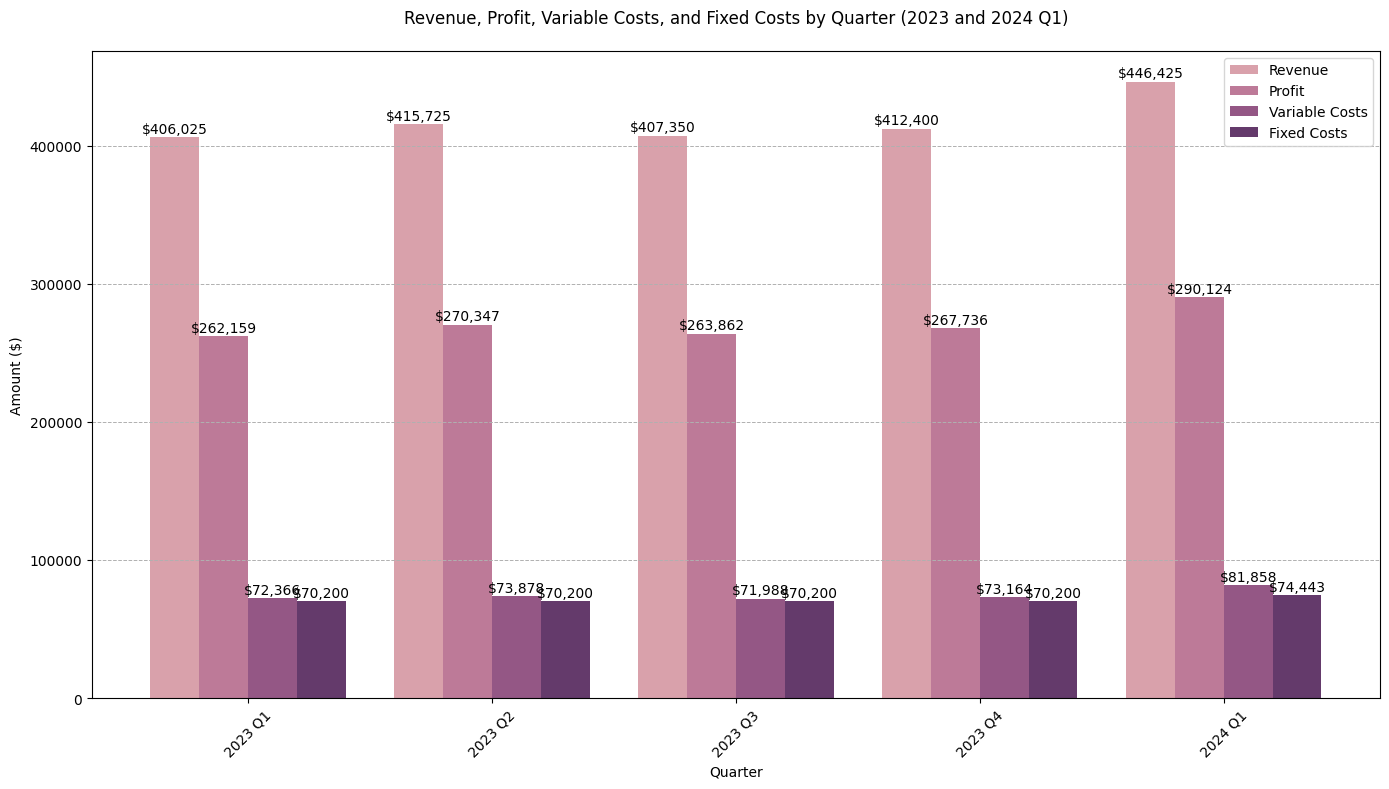

In [10]:
# Quarter labels
quarters = ['2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1']

# Data for each quarter
revenue = [revenue_q1_2023, revenue_q2_2023, revenue_q3_2023, revenue_q4_2023, revenue_q1_2024]
profit = [profit_q1_2023, profit_q2_2023, profit_q3_2023, profit_q4_2023, profit_q1_2024]
variable_costs = [variable_costs_q1, variable_costs_q2, variable_costs_q3, variable_costs_q4, variable_costs_q1_2024]
fixed_costs = [70200] * 4 + [fixed_costs_q1_2024]  # Assuming constant fixed costs across quarters

plt.figure(figsize=(14, 8))
palette = sns.cubehelix_palette(n_colors=4, light=0.7, dark=0.3)

bar_width = 0.2
index = np.arange(len(quarters))

# bars for each category
bar1 = plt.bar(index, revenue, bar_width, label='Revenue', color=palette[0])
bar2 = plt.bar(index + bar_width, profit, bar_width, label='Profit', color=palette[1])
bar3 = plt.bar(index + bar_width * 2, variable_costs, bar_width, label='Variable Costs', color=palette[2])
bar4 = plt.bar(index + bar_width * 3, fixed_costs, bar_width, label='Fixed Costs', color=palette[3])

# labels on top 
for bars in [bar1, bar2, bar3, bar4]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, f"${yval:,.0f}", ha='center', va='bottom')

plt.title('Revenue, Profit, Variable Costs, and Fixed Costs by Quarter (2023 and 2024 Q1)', pad=20)
plt.xlabel('Quarter')
plt.ylabel('Amount ($)')
plt.xticks(index + bar_width * 1.5, quarters, rotation=45)
plt.legend()

plt.grid(True, axis='y', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

In [11]:
sns_palette = sns.cubehelix_palette(n_colors=6, light=0.7, dark=0.3).as_hex()

financial_fig = go.Figure()

financial_fig.add_trace(go.Bar(
    x=quarters, 
    y=revenue, 
    name='Revenue',
    marker_color=sns_palette[0]  
))

financial_fig.add_trace(go.Bar(
    x=quarters, 
    y=profit, 
    name='Profit',
    marker_color=sns_palette[2]  
))

financial_fig.add_trace(go.Bar(
    x=quarters, 
    y=variable_costs, 
    name='Variable Costs',
    marker_color=sns_palette[4]  
))

financial_fig.add_trace(go.Bar(
    x=quarters, 
    y=fixed_costs, 
    name='Fixed Costs',
    marker_color=sns_palette[5]  
))

financial_fig.update_layout(
    title={'text': 'Revenue, Profit, Variable Costs,<br> and Fixed Costs <br> by Quarter (2023 and 2024 Q1)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'t': 40}
          },
    margin={'t': 100},
    legend=dict(
        orientation="h",  
        yanchor="bottom",
        y=-0.9,  
        xanchor="center",
        x=0.5
    ),
    xaxis=dict(title='Quarter'),
    yaxis=dict(title='Amount ($)'),
    barmode='group',  
    bargap=0.15,  
    bargroupgap=0.1,  
)

financial_fig = update_figure_layout(financial_fig)

09:31:57 - cmdstanpy - INFO - Chain [1] start processing
09:31:57 - cmdstanpy - INFO - Chain [1] done processing
09:31:57 - cmdstanpy - INFO - Chain [1] start processing
09:31:57 - cmdstanpy - INFO - Chain [1] done processing
09:31:57 - cmdstanpy - INFO - Chain [1] start processing
09:31:57 - cmdstanpy - INFO - Chain [1] done processing
09:31:57 - cmdstanpy - INFO - Chain [1] start processing
09:31:57 - cmdstanpy - INFO - Chain [1] done processing


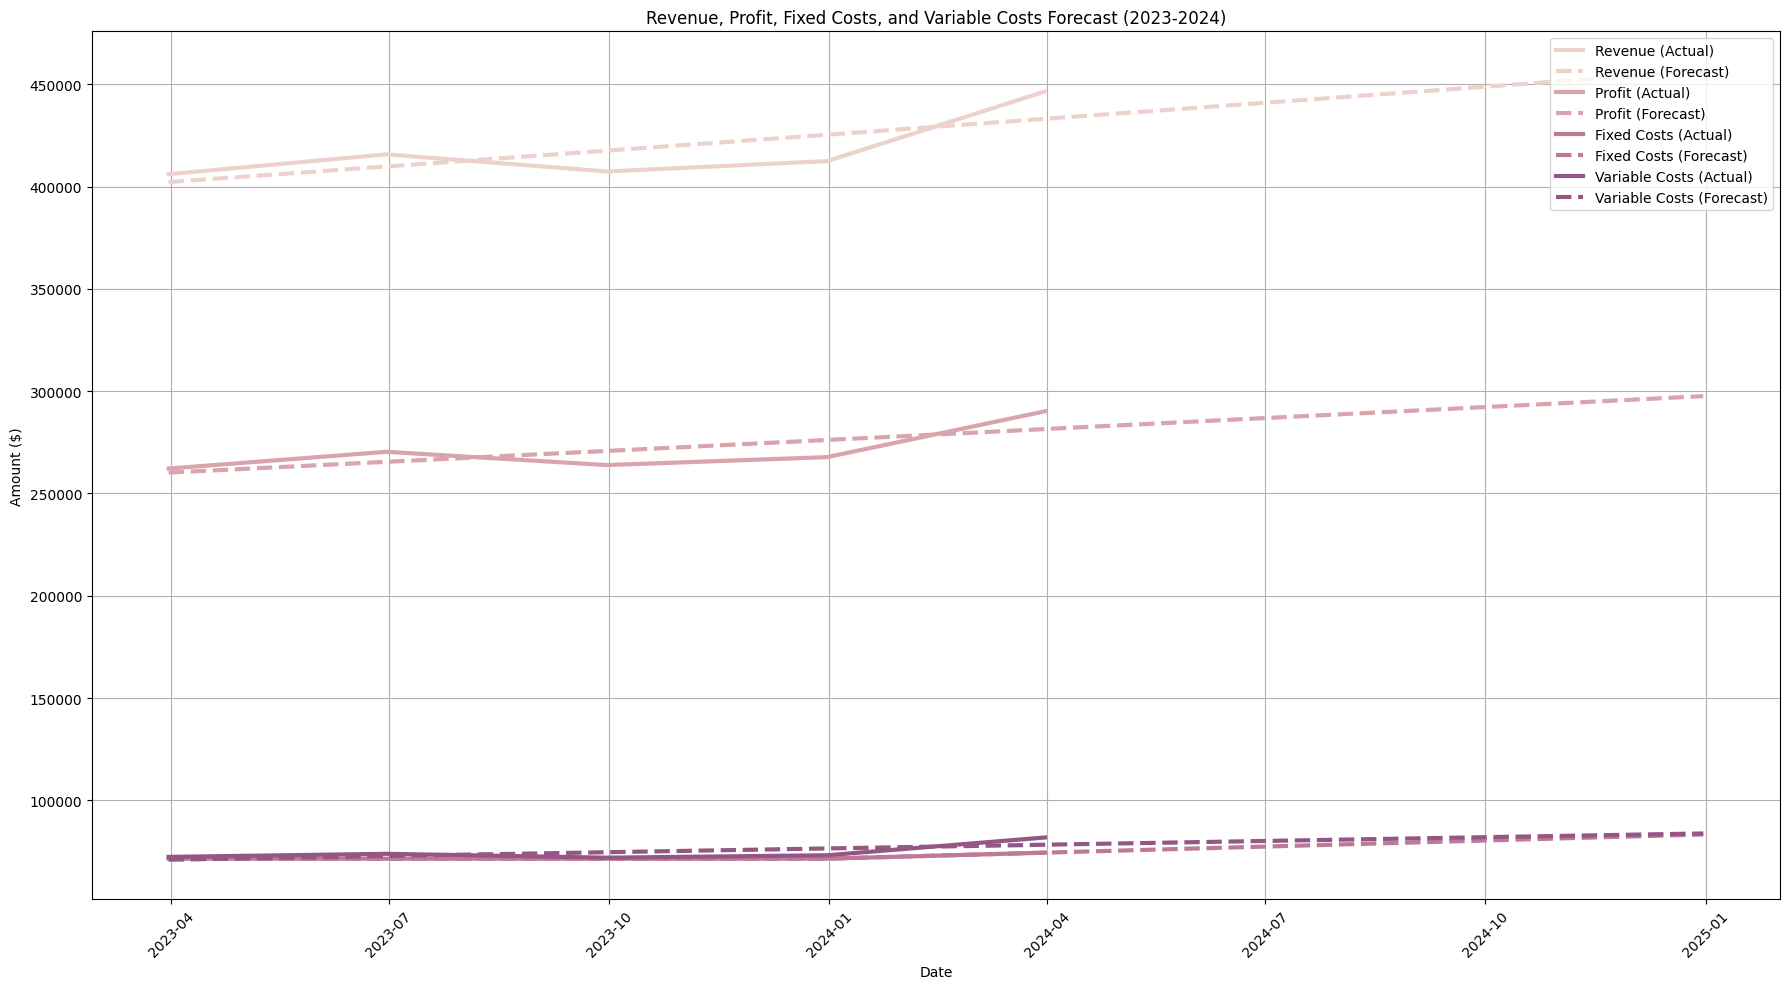

In [12]:
quarters = ['2023Q1', '2023Q2', '2023Q3', '2023Q4', '2024Q1']

# Revenue 
df_revenue = pd.DataFrame({
    'ds': pd.date_range(start='2023-01-01', periods=5, freq='Q'),  # Quarterly data
    'y': [revenue_q1_2023, revenue_q2_2023, revenue_q3_2023, revenue_q4_2023, revenue_q1_2024]
})

# Profit 
df_profit = pd.DataFrame({
    'ds': pd.date_range(start='2023-01-01', periods=5, freq='Q'),  # Quarterly data
    'y': [profit_q1_2023, profit_q2_2023, profit_q3_2023, profit_q4_2023, profit_q1_2024]
})

# Fixed Costs 
df_fixed_costs = pd.DataFrame({
    'ds': pd.date_range(start='2023-01-01', periods=5, freq='Q'),  # Quarterly data
    'y': [fixed_costs_2023, fixed_costs_2023, fixed_costs_2023, fixed_costs_2023, fixed_costs_q1_2024]
})

# Variable Costs 
df_variable_costs = pd.DataFrame({
    'ds': pd.date_range(start='2023-01-01', periods=5, freq='Q'),  # Quarterly data
    'y': [variable_costs_q1, variable_costs_q2, variable_costs_q3, variable_costs_q4, variable_costs_q1_2024]
})

# Step 2: Forecast w/ Prophet
def forecast_values(df, periods=3):
    model = Prophet()  
    df = df.copy()  
    model.fit(df)
    future = model.make_future_dataframe(periods=periods, freq='Q')
    forecast = model.predict(future)
    return forecast

df_revenue['y'] = pd.to_numeric(df_revenue['y'], errors='coerce')

# Forecast for Revenue
forecast_revenue = forecast_values(df_revenue)
# Forecast for Profit
forecast_profit = forecast_values(df_profit)
# Forecast for Fixed Costs
forecast_fixed_costs = forecast_values(df_fixed_costs)
# Forecast for Variable Costs
forecast_variable_costs = forecast_values(df_variable_costs)

palette = sns.cubehelix_palette(as_cmap=False)

plt.figure(figsize=(18, 10))

# Plot actual and forecasted values for Revenue
plt.plot(df_revenue['ds'], df_revenue['y'], label='Revenue (Actual)', color=palette[0], linestyle='-', linewidth=3)
plt.plot(forecast_revenue['ds'], forecast_revenue['yhat'], label='Revenue (Forecast)', color=palette[0], linestyle='--', linewidth=3)

# Plot actual and forecasted values for Profit
plt.plot(df_profit['ds'], df_profit['y'], label='Profit (Actual)', color=palette[1], linestyle='-', linewidth=3)
plt.plot(forecast_profit['ds'], forecast_profit['yhat'], label='Profit (Forecast)', color=palette[1], linestyle='--', linewidth=3)

# Plot actual and forecasted values for Fixed Costs
plt.plot(df_fixed_costs['ds'], df_fixed_costs['y'], label='Fixed Costs (Actual)', color=palette[2], linestyle='-', linewidth=3)
plt.plot(forecast_fixed_costs['ds'], forecast_fixed_costs['yhat'], label='Fixed Costs (Forecast)', color=palette[2], linestyle='--', linewidth=3)

# Plot actual and forecasted values for Variable Costs
plt.plot(df_variable_costs['ds'], df_variable_costs['y'], label='Variable Costs (Actual)', color=palette[3], linestyle='-', linewidth=3)
plt.plot(forecast_variable_costs['ds'], forecast_variable_costs['yhat'], label='Variable Costs (Forecast)', color=palette[3], linestyle='--', linewidth=3)

plt.title('Revenue, Profit, Fixed Costs, and Variable Costs Forecast (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
forecast_fig = go.Figure()

actual_color_1 = sns_palette[0]
forecast_color_1 = sns_palette[0]
actual_color_2 = sns_palette[1]
forecast_color_2 = sns_palette[1]
actual_color_3 = sns_palette[2]
forecast_color_3 = sns_palette[2]
actual_color_4 = sns_palette[3]
forecast_color_4 = sns_palette[3]

# Actual Revenue (solid line)
forecast_fig.add_trace(go.Scatter(
    x=df_revenue['ds'], y=df_revenue['y'],
    mode='lines', name='Revenue (Actual)', line=dict(color=actual_color_1, width=3)
))

# Forecasted Revenue (dashed line)
forecast_fig.add_trace(go.Scatter(
    x=forecast_revenue['ds'], y=forecast_revenue['yhat'],
    mode='lines', name='Revenue (Forecast)', line=dict(color=forecast_color_1, width=3, dash='dash')
))

# Actual Profit (solid line)
forecast_fig.add_trace(go.Scatter(
    x=df_profit['ds'], y=df_profit['y'],
    mode='lines', name='Profit (Actual)', line=dict(color=actual_color_2, width=3)
))

# Forecasted Profit (dashed line)
forecast_fig.add_trace(go.Scatter(
    x=forecast_profit['ds'], y=forecast_profit['yhat'],
    mode='lines', name='Profit (Forecast)', line=dict(color=forecast_color_2, width=3, dash='dash')
))

# Actual Fixed Costs (solid line)
forecast_fig.add_trace(go.Scatter(
    x=df_fixed_costs['ds'], y=df_fixed_costs['y'],
    mode='lines', name='Fixed Costs (Actual)', line=dict(color=actual_color_3, width=3)
))

# Forecasted Fixed Costs (dashed line)
forecast_fig.add_trace(go.Scatter(
    x=forecast_fixed_costs['ds'], y=forecast_fixed_costs['yhat'],
    mode='lines', name='Fixed Costs (Forecast)', line=dict(color=forecast_color_3, width=3, dash='dash')
))

# Actual Variable Costs (solid line)
forecast_fig.add_trace(go.Scatter(
    x=df_variable_costs['ds'], y=df_variable_costs['y'],
    mode='lines', name='Variable Costs (Actual)', line=dict(color=actual_color_4, width=3)
))

# Forecasted Variable Costs (dashed line)
forecast_fig.add_trace(go.Scatter(
    x=forecast_variable_costs['ds'], y=forecast_variable_costs['yhat'],
    mode='lines', name='Variable Costs (Forecast)', line=dict(color=forecast_color_4, width=3, dash='dash')
))

forecast_fig.update_layout(
    title={'text': 'Revenue, Profit, Fixed Costs,<br> and Variable Costs Forecast (2023-2024)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'t': 50}
          },
    margin={'t': 100},
    legend=dict(
        orientation="h",  
        yanchor="bottom",
        y=-0.9,  
        xanchor="center",
        x=0.5
    ),
    height=600,  
    xaxis=dict(title='Date'),
    yaxis=dict(title='Amount ($)'),
    hovermode='x unified'
)

financial_forecast_fig = update_figure_layout(forecast_fig)

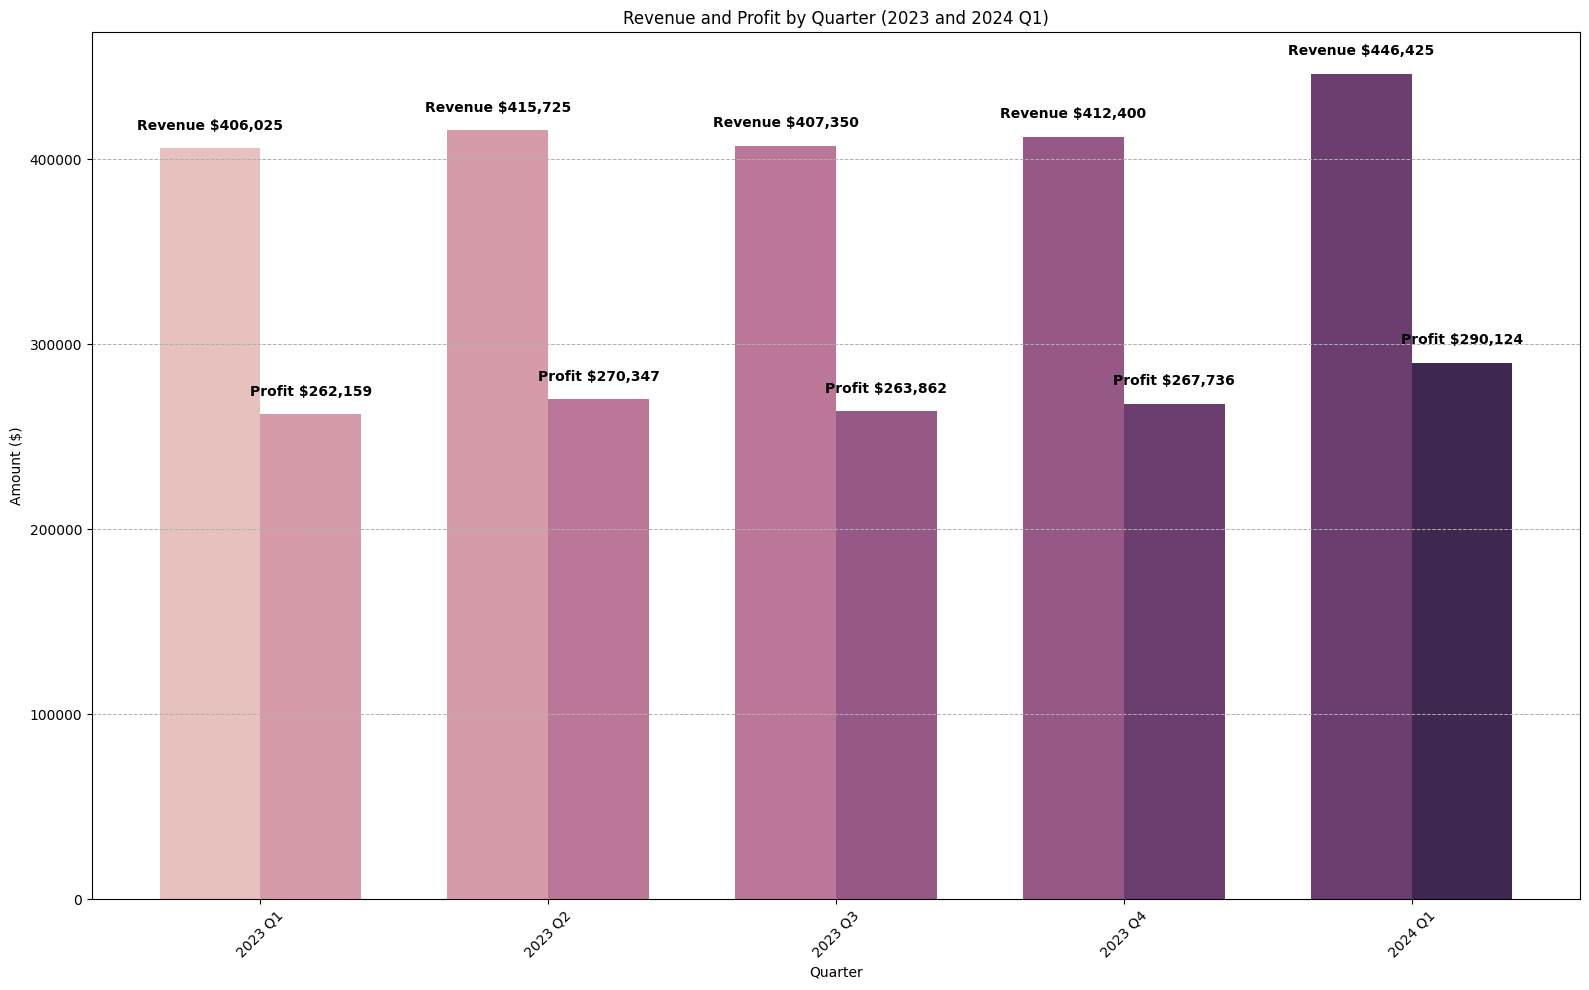

In [14]:
# Data for revenue and profit for each quarter
quarters = ['2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1']
revenue = [revenue_q1_2023, revenue_q2_2023, revenue_q3_2023, revenue_q4_2023, revenue_q1_2024]
profit = [profit_q1_2023, profit_q2_2023, profit_q3_2023, profit_q4_2023, profit_q1_2024]

cmap = sns.cubehelix_palette(light=0.8, dark=0.2, as_cmap=True)

num_cols = len(quarters)
colors_revenue = [cmap(i / num_cols) for i in range(0, num_cols)]
colors_profit = [cmap((i + 1) / num_cols) for i in range(0, num_cols)]


fig, ax = plt.subplots(figsize=(16, 10))

# Plot revenue
bar_width = 0.35
index = np.arange(len(quarters))
bar1 = ax.bar(index, revenue, bar_width, label='Revenue', color=colors_revenue)

# Plot profit
bar2 = ax.bar(index + bar_width, profit, bar_width, label='Profit', color=colors_profit)

ax.set_xlabel('Quarter')
ax.set_ylabel('Amount ($)')
ax.set_title('Revenue and Profit by Quarter (2023 and 2024 Q1)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(quarters, rotation=45)

ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

# Add labels directly on the bars
for i, v in enumerate(revenue):
    ax.text(i, v + 10000, f'Revenue ${v:,.0f}', color='black', ha='center', fontweight='bold')
for i, v in enumerate(profit):
    ax.text(i + bar_width, v + 10000, f'Profit ${v:,.0f}', color='black', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
num_cols = len(quarters)

colors_revenue = sns.cubehelix_palette(n_colors=num_cols, light=0.7, dark=0.3).as_hex()  # Lighter to darker for revenue
colors_profit = sns.cubehelix_palette(n_colors=num_cols, light=0.5, dark=0.1).as_hex()   # Lighter to darker for profit (darker than revenue)

revenue_profit_fig = go.Figure()

for i in range(num_cols):
    revenue_profit_fig.add_trace(go.Bar(
        x=[quarters[i]],  
        y=[revenue[i]],
        name=f'Revenue {quarters[i]}',
        marker_color=colors_revenue[i],  
        offsetgroup=0
    ))

for i in range(num_cols):
    revenue_profit_fig.add_trace(go.Bar(
        x=[quarters[i]],  
        y=[profit[i]],
        name=f'Profit {quarters[i]}',
        marker_color=colors_profit[i],  
        offsetgroup=1
    ))

revenue_profit_fig.update_layout(
    title={'text': 'Revenue and Profit<br> by Quarter (2023 and 2024 Q1)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    xaxis=dict(title='Quarter'),
    yaxis=dict(title='Amount ($)'),
    barmode='group',  
    bargap=0.15,  
    bargroupgap=0.1,
    hovermode="x unified" 
)

revenue_profit_plot = update_figure_layout(revenue_profit_fig)

In [16]:
patient_df_2023 = pd.read_csv('patient_data.csv')
patient_df_2024 = pd.read_csv('patient_data_Q1_24.csv')

# Merge 2023 appointment data with 2023 patient data for each quarter
merged_q1_2023 = pd.merge(q1_2023, patient_df_2023, on='PatientID', how='inner')
merged_q2_2023 = pd.merge(q2_2023, patient_df_2023, on='PatientID', how='inner')
merged_q3_2023 = pd.merge(q3_2023, patient_df_2023, on='PatientID', how='inner')
merged_q4_2023 = pd.merge(q4_2023, patient_df_2023, on='PatientID', how='inner')

# Merge 2024 Q1 appointment data with 2024 patient data
merged_q1_2024 = pd.merge(q1_2024, patient_df_2024, on='PatientID', how='inner')

# Group by Diagnosis and find total revenue for each quarter
revenue_q1_2023 = merged_q1_2023.groupby('Diagnosis')['Patient_Charges'].sum()
revenue_q2_2023 = merged_q2_2023.groupby('Diagnosis')['Patient_Charges'].sum()
revenue_q3_2023 = merged_q3_2023.groupby('Diagnosis')['Patient_Charges'].sum()
revenue_q4_2023 = merged_q4_2023.groupby('Diagnosis')['Patient_Charges'].sum()
revenue_q1_2024 = merged_q1_2024.groupby('Diagnosis')['Patient_Charges'].sum()

# Combine all 
revenue_by_diagnosis = pd.DataFrame({
    '2023 Q1': revenue_q1_2023,
    '2023 Q2': revenue_q2_2023,
    '2023 Q3': revenue_q3_2023,
    '2023 Q4': revenue_q4_2023,
    '2024 Q1': revenue_q1_2024
}).fillna(0)  

print(revenue_by_diagnosis)

           2023 Q1  2023 Q2  2023 Q3  2023 Q4  2024 Q1
Diagnosis                                             
ADHD         77975    70450    73575    79925    83850
Anxiety     109025   118725   109850   106950   139850
Autism      219025   226550   223925   225525   222725


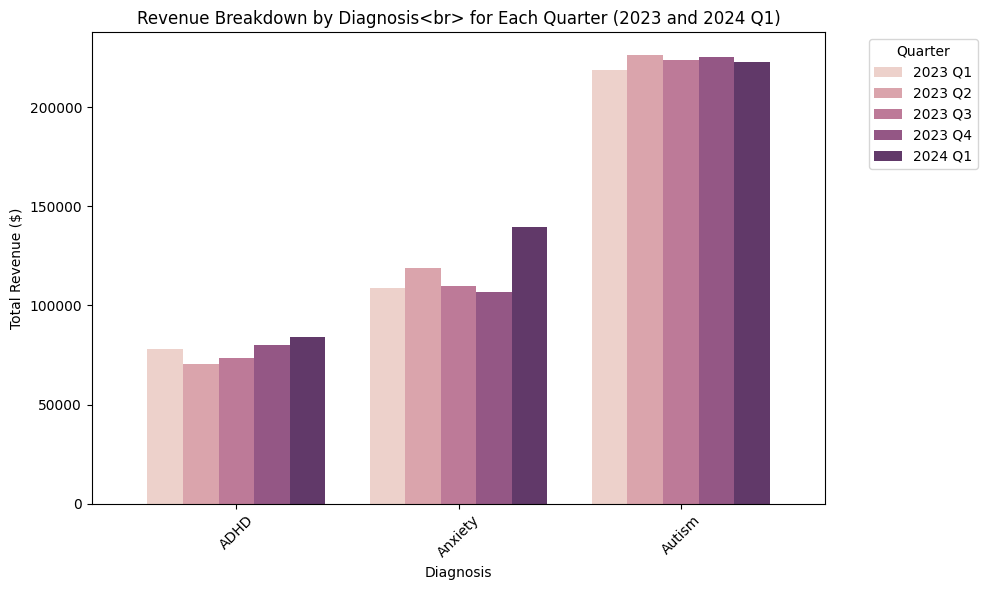

In [17]:
cmap = sns.cubehelix_palette(as_cmap=True)

num_cols = len(revenue_by_diagnosis.columns)
colors = [cmap(i / num_cols) for i in range(num_cols)]

fig, ax = plt.subplots(figsize=(10, 6))

revenue_by_diagnosis.plot(kind='bar', ax=ax, width=0.8, color=colors)

ax.set_title('Revenue Breakdown by Diagnosis<br> for Each Quarter (2023 and 2024 Q1)')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Total Revenue ($)')
plt.xticks(rotation=45)

ax.legend(title='Quarter', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

In [18]:
num_quarters = len(revenue_by_diagnosis.columns)

colors = sns.cubehelix_palette(n_colors=num_quarters, light=0.7, dark=0.3).as_hex()

revenue_diagnosis_fig = go.Figure()

quarters = revenue_by_diagnosis.columns
diagnoses = revenue_by_diagnosis.index

for i, quarter in enumerate(quarters):
    revenue_diagnosis_fig.add_trace(go.Bar(
        x=diagnoses,
        y=revenue_by_diagnosis[quarter],
        name=quarter,
        marker_color=colors[i],  
        offsetgroup=i  
    ))

revenue_diagnosis_fig.update_layout(
    title={'text': 'Revenue Breakdown by Diagnosis<br> for Each Quarter (2023 and 2024 Q1)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    xaxis=dict(title='Diagnosis'),
    yaxis=dict(title='Total Revenue ($)'),
    barmode='group',  
    bargap=0.15,  
    bargroupgap=0.1,  
    hovermode='x unified',
    legend_title_text='Quarter'
)

revenue_diagnosis_plot = update_figure_layout(revenue_diagnosis_fig)

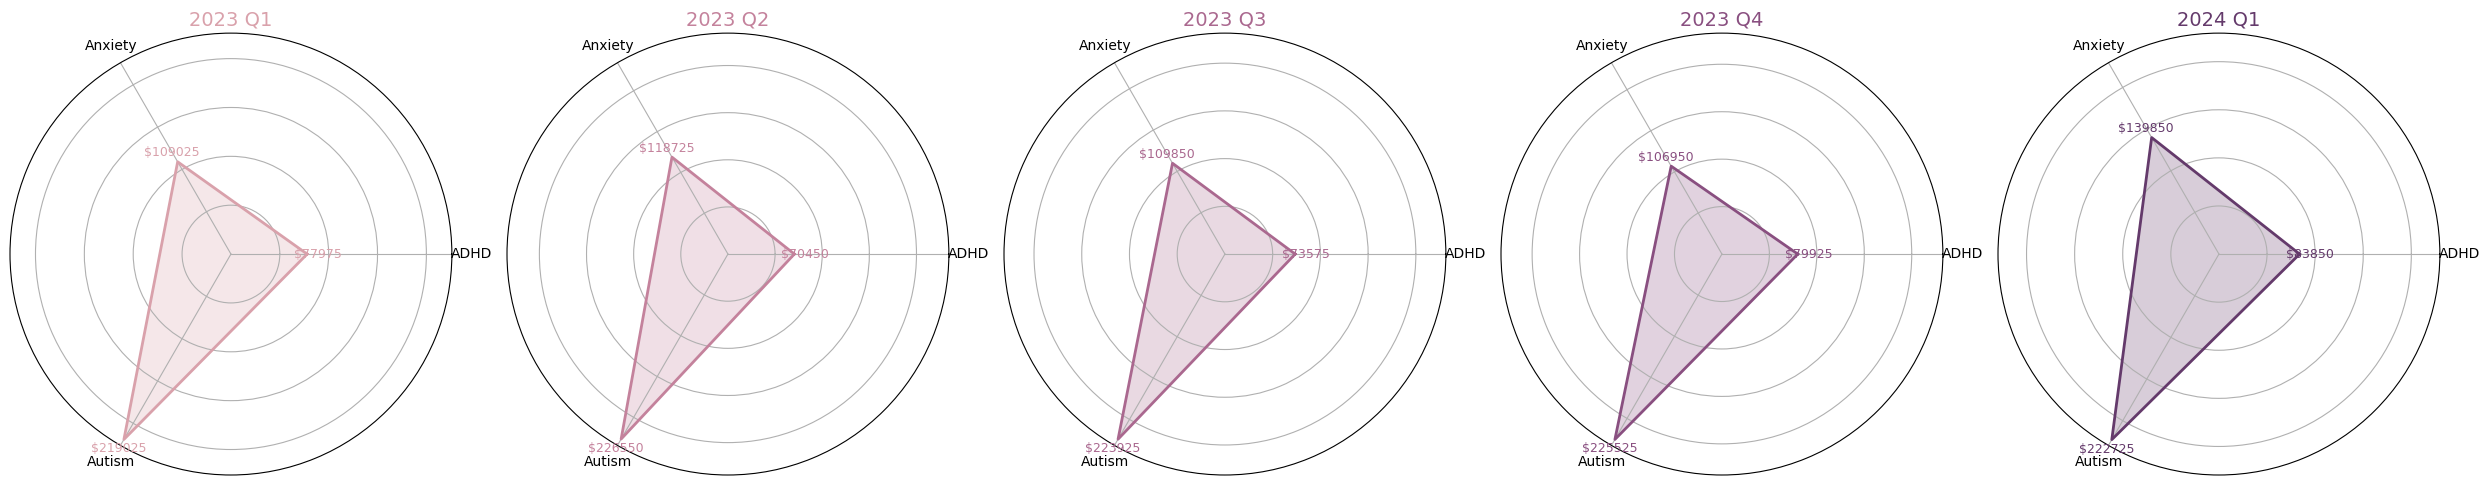

In [19]:
revenue_by_diagnosis = pd.DataFrame({
    '2023 Q1': revenue_q1_2023,
    '2023 Q2': revenue_q2_2023,
    '2023 Q3': revenue_q3_2023,
    '2023 Q4': revenue_q4_2023,
    '2024 Q1': revenue_q1_2024
}).fillna(0)  

diagnoses = revenue_by_diagnosis.index.tolist()

# Define the angles for the radar chart (one per diagnosis)
angles = np.linspace(0, 2 * np.pi, len(diagnoses), endpoint=False).tolist()
angles += angles[:1]  

fig, axes = plt.subplots(1, 5, figsize=(25, 6), subplot_kw=dict(polar=True))

palette = sns.cubehelix_palette(n_colors=5, light=0.7, dark=0.3)

quarters = ['2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1']

for i, quarter in enumerate(quarters):
    values = revenue_by_diagnosis[quarter].tolist()
    values += values[:1]
    
    # radar chart for this quarter
    axes[i].fill(angles, values, color=palette[i], alpha=0.25)
    axes[i].plot(angles, values, color=palette[i], linewidth=2)
    
    # labels for each diagnosis
    axes[i].set_xticks(angles[:-1])
    axes[i].set_xticklabels(diagnoses, size=10)
    
    axes[i].set_title(quarter, size=14, color=palette[i])
    
    axes[i].set_yticklabels([])
    
    for angle, value in zip(angles, values[:-1]):  
        axes[i].text(angle, value + max(values) * 0.05, f'${value:.0f}', ha='center', va='center', fontsize=9, color=palette[i])

plt.tight_layout()
plt.show()

In [20]:
diagnoses = revenue_by_diagnosis.index.tolist()

angles = np.linspace(0, 2 * np.pi, len(diagnoses), endpoint=False).tolist()
angles += angles[:1]

num_quarters = len(quarters)

colors = sns.cubehelix_palette(n_colors=num_quarters, light=0.7, dark=0.3).as_hex()

fig = make_subplots(rows=1, cols=num_quarters, 
                    specs=[[{'type': 'polar'}] * num_quarters],
                    subplot_titles=quarters)

for i, quarter in enumerate(quarters):
    # Get revenue values for the current quarter and repeat the first value to close the chart
    values = revenue_by_diagnosis[quarter].tolist()
    values += values[:1]
    
    # Add radar chart for the current quarter
    fig.add_trace(go.Scatterpolar(
        r=values,  
        theta=diagnoses + [diagnoses[0]],  
        fill='toself',
        name=quarter,
        marker=dict(color=colors[i])  
    ), row=1, col=i+1)  

fig.update_layout(
    title={'text': "Revenue Breakdown by Diagnosis<br> for Each Quarter",
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=False 
)

radar_chart_plot = update_figure_layout(fig)

In [21]:
# Concatenate appointment data for 2023 and Q1 2024
appointment_data = pd.concat([q1_2023, q2_2023, q3_2023, q4_2023, q1_2024])

# Combine patient data for 2023 and 2024 Q1
patient_data = pd.concat([patient_df_2023, patient_df_2024])

# Merge appointment data with patient data 
merged_data = pd.merge(appointment_data, patient_data, on='PatientID', how='inner')

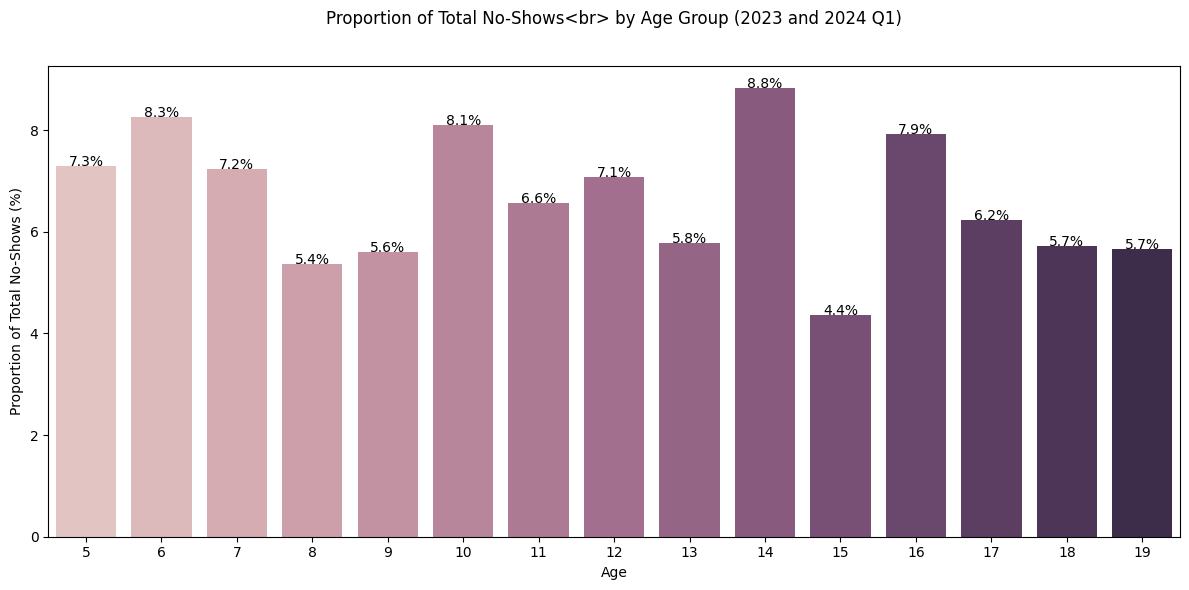

In [22]:
bins = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
labels = [str(i) for i in bins[:-1]] 

# binning by age
merged_data['Age_Group'] = pd.cut(merged_data['Age'], bins=bins, labels=labels, right=False)

merged_data = merged_data.dropna(subset=['Age_Group'])

appointments_per_age_group = merged_data.groupby('Age_Group', observed=True)['No_Show'].count()
no_shows_per_age_group = merged_data.groupby('Age_Group', observed=True)['No_Show'].sum()

total_no_shows = no_shows_per_age_group.sum()  
no_show_rate = (no_shows_per_age_group / total_no_shows) * 100  
no_show_rate = no_show_rate.reset_index()

no_show_rate = no_show_rate.dropna()

palette = sns.cubehelix_palette(n_colors=len(no_show_rate), light=0.8, dark=0.2)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Age_Group', y='No_Show', data=no_show_rate, palette=palette)

# Add data labels on top of each bar, adjusting position to avoid overlap
for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height,  
        s=f'{height:.1f}%',
        ha='center'
    )

plt.title('Proportion of Total No-Shows<br> by Age Group (2023 and 2024 Q1)', pad=30)  
plt.xlabel('Age')
plt.ylabel('Proportion of Total No-Shows (%)')
plt.xticks(rotation=0) 

plt.subplots_adjust(top=0.8)  

plt.tight_layout()
plt.show()

In [23]:
num_age_groups = len(no_show_rate['Age_Group'])

colors = sns.cubehelix_palette(n_colors=num_age_groups, light=0.7, dark=0.3).as_hex()

no_show_age_group_fig = go.Figure()

for i, age_group in enumerate(no_show_rate['Age_Group']):
    no_show_age_group_fig.add_trace(go.Bar(
        x=[age_group],
        y=[no_show_rate['No_Show'][i]],
        name=age_group,  
        marker_color=colors[i],  
        text=[f'{no_show_rate["No_Show"][i]:.1f}%'],  
        textposition='outside' 
    ))

no_show_age_group_fig.update_layout(
    title={'text': 'Proportion of Total No-Shows<br> by Age Group (2023 and 2024 Q1)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    xaxis=dict(title='Age'),
    yaxis=dict(title='Proportion of Total No-Shows (%)'),
    hovermode='x unified',
    bargap=0.2 
)

no_show_age_group_plot = update_figure_layout(no_show_age_group_fig)

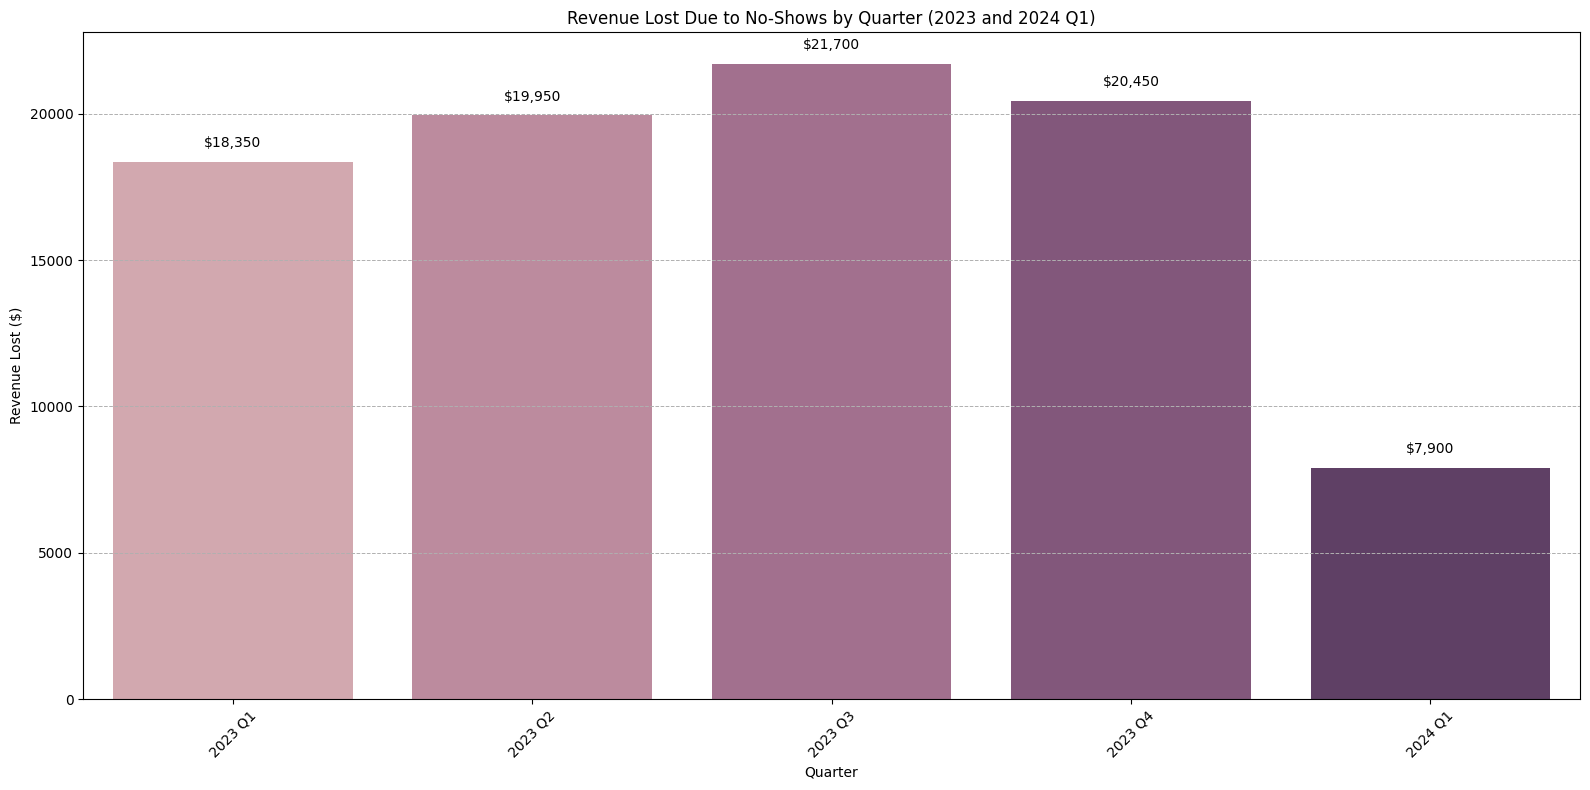

In [24]:
datasets = [q1_2023, q2_2023, q3_2023, q4_2023, q1_2024]
quarters = ['2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1']

revenue_lost = []

for dataset in datasets:
    no_show_count = dataset[dataset['No_Show'] == 1].shape[0]
    lost_revenue = no_show_count * 50  # $50 per no-show
    revenue_lost.append(lost_revenue)

plt.figure(figsize=(16, 8))
palette = sns.cubehelix_palette(n_colors=len(quarters), light=0.7, dark=0.3)

ax = sns.barplot(x=quarters, y=revenue_lost, palette=palette)

for i, value in enumerate(revenue_lost):
    ax.text(i, value + 500, f"${value:,.0f}", ha='center')

plt.title('Revenue Lost Due to No-Shows by Quarter (2023 and 2024 Q1)')
plt.xlabel('Quarter')
plt.ylabel('Revenue Lost ($)')
plt.xticks(rotation=45)

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

In [25]:
num_quarters = len(quarters)

colors = sns.cubehelix_palette(n_colors=num_quarters, light=0.7, dark=0.3).as_hex()

revenue_lost_fig = go.Figure()

for i, quarter in enumerate(quarters):
    revenue_lost_fig.add_trace(go.Bar(
        x=[quarter],
        y=[revenue_lost[i]],
        name=quarter,  
        marker_color=colors[i],  
        text=[f'${revenue_lost[i]:,.0f}'],  
        textposition='outside'  
    ))

revenue_lost_fig.update_layout(
    title={'text': 'Revenue Lost Due to No-Shows<br> by Quarter (2023 and 2024 Q1)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    xaxis=dict(title='Quarter'),
    yaxis=dict(title='Revenue Lost ($)'),
    hovermode='x unified',
    bargap=0.2  
)

revenue_lost_plot = update_figure_layout(revenue_lost_fig)

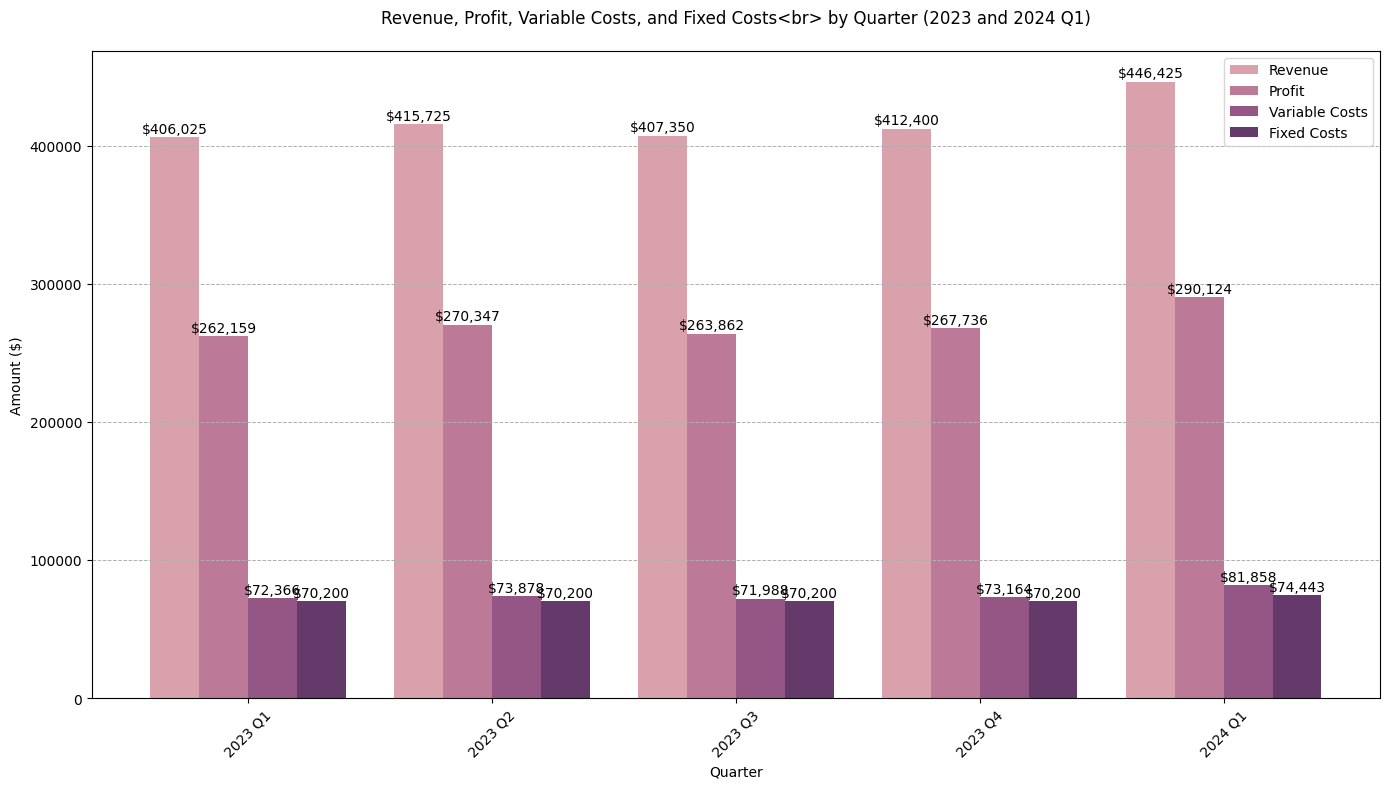

In [26]:
quarters = ['2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1']

plt.figure(figsize=(14, 8))
palette = sns.cubehelix_palette(n_colors=4, light=0.7, dark=0.3)

bar_width = 0.2
index = np.arange(len(quarters))

bar1 = plt.bar(index, revenue, bar_width, label='Revenue', color=palette[0])
bar2 = plt.bar(index + bar_width, profit, bar_width, label='Profit', color=palette[1])
bar3 = plt.bar(index + bar_width * 2, variable_costs, bar_width, label='Variable Costs', color=palette[2])
bar4 = plt.bar(index + bar_width * 3, fixed_costs, bar_width, label='Fixed Costs', color=palette[3])

for bars in [bar1, bar2, bar3, bar4]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1000, f"${yval:,.0f}", ha='center', va='bottom')

plt.title('Revenue, Profit, Variable Costs, and Fixed Costs<br> by Quarter (2023 and 2024 Q1)', pad=20)
plt.xlabel('Quarter')
plt.ylabel('Amount ($)')
plt.xticks(index + bar_width * 1.5, quarters, rotation=45)
plt.legend()

plt.grid(True, axis='y', linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

In [27]:
num_quarters = len(quarters)

colors_revenue = sns.cubehelix_palette(n_colors=num_quarters, light=0.7, dark=0.3).as_hex()  
colors_profit = sns.cubehelix_palette(n_colors=num_quarters, light=0.6, dark=0.2).as_hex()   
colors_variable_costs = sns.cubehelix_palette(n_colors=num_quarters, light=0.5, dark=0.15).as_hex()  
colors_fixed_costs = sns.cubehelix_palette(n_colors=num_quarters, light=0.4, dark=0.1).as_hex()  

financial_overview_fig = go.Figure()

for i, quarter in enumerate(quarters):
    financial_overview_fig.add_trace(go.Bar(
        x=[quarter],
        y=[revenue[i]],
        name=f'Revenue {quarter}',
        marker_color=colors_revenue[i],
        text=[f'${revenue[i]:,.0f}'],
        textposition='outside'
    ))

for i, quarter in enumerate(quarters):
    financial_overview_fig.add_trace(go.Bar(
        x=[quarter],
        y=[profit[i]],
        name=f'Profit {quarter}',
        marker_color=colors_profit[i],
        text=[f'${profit[i]:,.0f}'],
        textposition='outside'
    ))

# Add bars for Variable Costs 
for i, quarter in enumerate(quarters):
    financial_overview_fig.add_trace(go.Bar(
        x=[quarter],
        y=[variable_costs[i]],
        name=f'Variable Costs {quarter}',
        marker_color=colors_variable_costs[i],
        text=[f'${variable_costs[i]:,.0f}'],
        textposition='outside'
    ))

# Add bars for Fixed Costs 
for i, quarter in enumerate(quarters):
    financial_overview_fig.add_trace(go.Bar(
        x=[quarter],
        y=[fixed_costs[i]],
        name=f'Fixed Costs {quarter}',
        marker_color=colors_fixed_costs[i],
        text=[f'${fixed_costs[i]:,.0f}'],
        textposition='outside'
    ))

financial_overview_fig.update_layout(
    title={'text': 'Revenue, Profit, Variable Costs, and Fixed Costs<br> by Quarter (2023 and 2024 Q1)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    xaxis=dict(title='Quarter'),
    yaxis=dict(title='Amount ($)'),
    barmode='group', 
    bargap=0.15,  
    hovermode='x unified',
    legend_title_text='Financial Overview'
)

financial_overview_plot = update_figure_layout(financial_overview_fig)

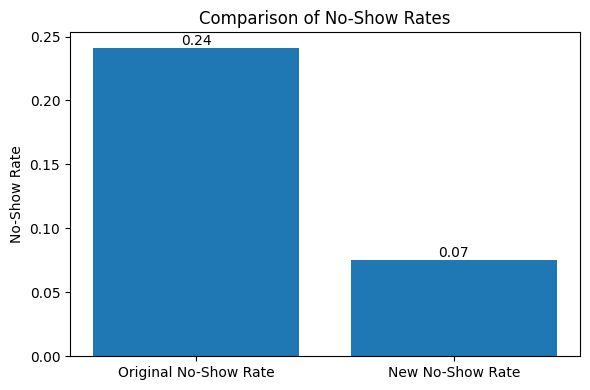

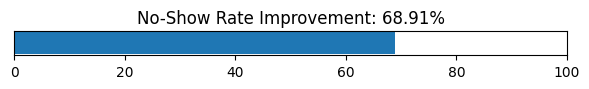

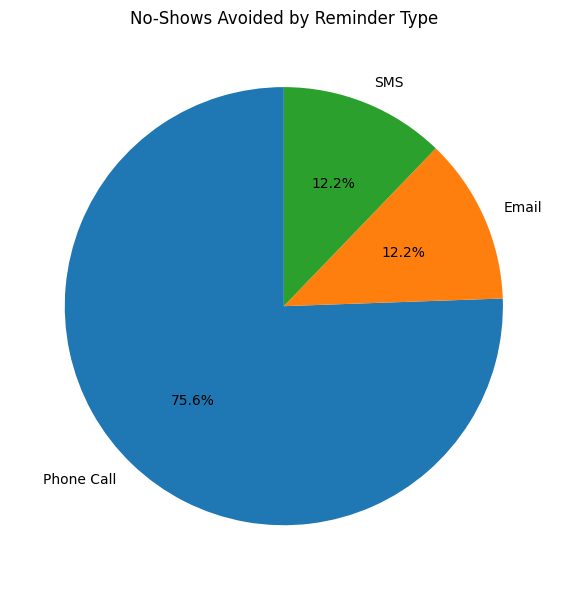

Original No-Show Rate: 24.12%
New No-Show Rate: 7.50%
Total No-Shows Avoided: 350
Total Revenue Gained: $61270.82


In [28]:
original_no_show_rate = 0.2412
new_no_show_rate = 0.0750
no_shows_avoided = 350
revenue_gained = 61270.82

# Proportions of no-shows avoided by reminder type
reminder_proportions = [0.755577, 0.122449, 0.121974]
reminder_labels = ['Phone Call', 'Email', 'SMS']

# --- Bar Chart: Compare original and new no-show rates ---
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Original No-Show Rate', 'New No-Show Rate'], [original_no_show_rate, new_no_show_rate])
ax.bar_label(bars, fmt='%.2f')
ax.set_ylabel('No-Show Rate')
ax.set_title('Comparison of No-Show Rates')

plt.tight_layout()
plt.show()

# --- Gauge-like Progress Bar: Improvement in No-Show Rates ---
improvement = (original_no_show_rate - new_no_show_rate) / original_no_show_rate * 100

fig, ax = plt.subplots(figsize=(6, 1))
ax.barh([0], [improvement])
ax.set_xlim(0, 100)
ax.set_yticks([])
ax.set_title(f'No-Show Rate Improvement: {improvement:.2f}%')

plt.tight_layout()
plt.show()

# --- Pie Chart: No-shows avoided by reminder type ---
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(reminder_proportions, labels=reminder_labels, autopct='%1.1f%%', startangle=90)
ax.set_title('No-Shows Avoided by Reminder Type')

plt.tight_layout()
plt.show()

print(f"Original No-Show Rate: {original_no_show_rate * 100:.2f}%")
print(f"New No-Show Rate: {new_no_show_rate * 100:.2f}%")
print(f"Total No-Shows Avoided: {no_shows_avoided}")
print(f"Total Revenue Gained: ${revenue_gained:.2f}")

In [29]:
colors = sns.cubehelix_palette(n_colors=2, light=0.7, dark=0.3).as_hex()

no_show_rate_fig = go.Figure()

no_show_rate_fig.add_trace(go.Bar(
    x=['Original No-Show Rate', 'New No-Show Rate'],
    y=[original_no_show_rate, new_no_show_rate],
    text=[f'{original_no_show_rate:.2f}', f'{new_no_show_rate:.2f}'],
    textposition='outside',
    marker_color=colors  
))

no_show_rate_fig.update_layout(
    title={'text': 'Comparison of No-Show Rates',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    yaxis=dict(title='No-Show Rate'),
    hovermode='x unified',
    bargap=0.2  
)

no_show_rate_plot = update_figure_layout(no_show_rate_fig)

In [30]:
sns_palette = sns.cubehelix_palette(n_colors=5, light=0.7, dark=0.3).as_hex()

# Gauge bar for no-show rate improvement 
improvement_gauge = go.Figure(go.Indicator(
    mode="gauge+number",
    value=improvement,
    number={'suffix': "%"},  # Add percent sign after the value
    gauge={
        'axis': {'range': [0, 100], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': sns_palette[4]},
        'steps': [
            {'range': [0, 50], 'color': sns_palette[0]},  
            {'range': [50, 100], 'color': sns_palette[2]}  
        ]
    },
    title={'text': "No-Show Rate Improvement (%)"}
))

improvement_gauge_plot = update_figure_layout(improvement_gauge)

In [31]:
num_labels = len(reminder_labels)
colors = sns.cubehelix_palette(n_colors=num_labels, light=0.7, dark=0.3).as_hex()

# Pie chart: Proportions of no-shows avoided by reminder type
reminder_pie_chart = go.Figure(go.Pie(
    labels=reminder_labels,
    values=reminder_proportions,
    hole=0.3, 
    textinfo='label+percent',
    marker=dict(colors=colors)  
))

reminder_pie_chart.update_layout(
    title={'text': "No-Shows Avoided by Reminder Type",
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}}
)

reminder_pie_chart_plot = update_figure_layout(reminder_pie_chart)

In [32]:
# Summary of key metrics (Markdown text)
key_metrics_summary = dcc.Markdown(f'''
### Key Metrics
- **Original No-Show Rate:** {original_no_show_rate * 100:.2f}%
- **New No-Show Rate:** {new_no_show_rate * 100:.2f}%
- **Total No-Shows Avoided:** {no_shows_avoided}
- **Total Revenue Gained:** ${revenue_gained:,.2f}
''')

In [33]:
patient_df = pd.read_csv("patient_data.csv")
appointment_df = pd.read_csv("appointment_data.csv")

In [34]:
appointment_df = appointment_df.drop(columns=['Distance_From_Clinic','Patient_Charges'])

In [35]:
merged_df = pd.merge(patient_df, appointment_df, on='PatientID', how='inner')

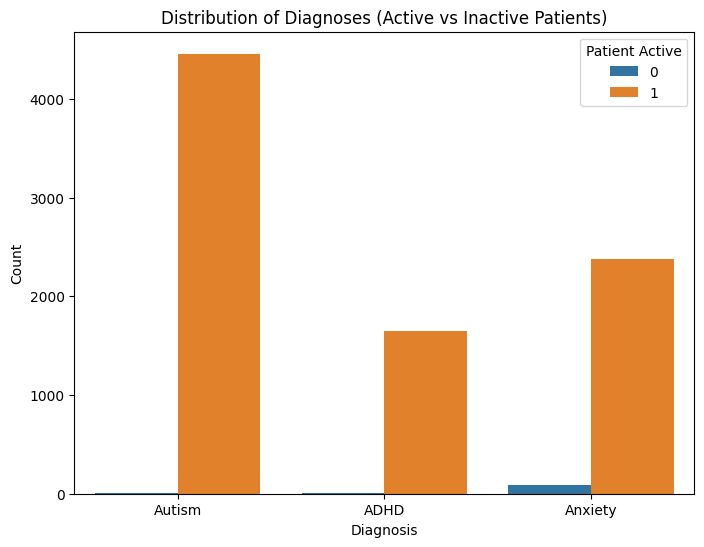

/var/folders/pc/mw8924qn53n51t5y4nmnrh5r0000gn/T/ipykernel_54478/3276054100.py:16: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



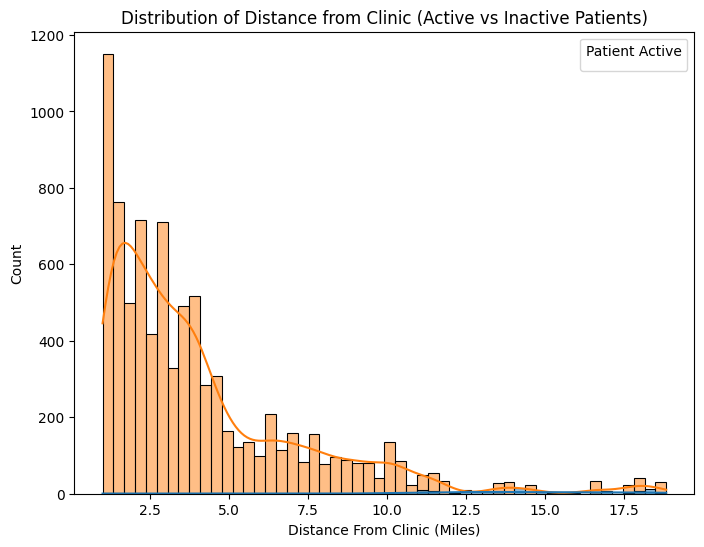

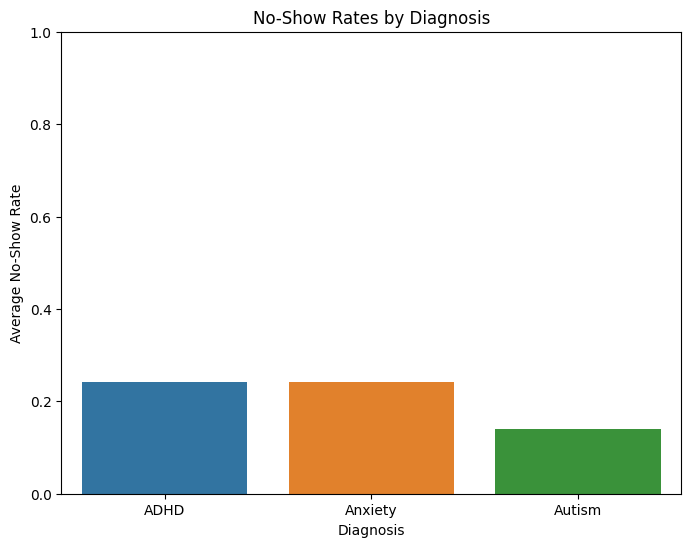

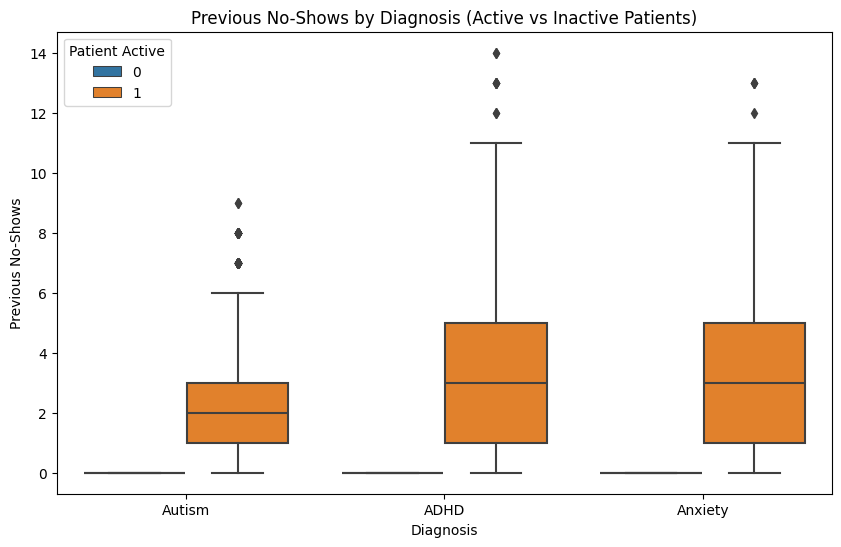

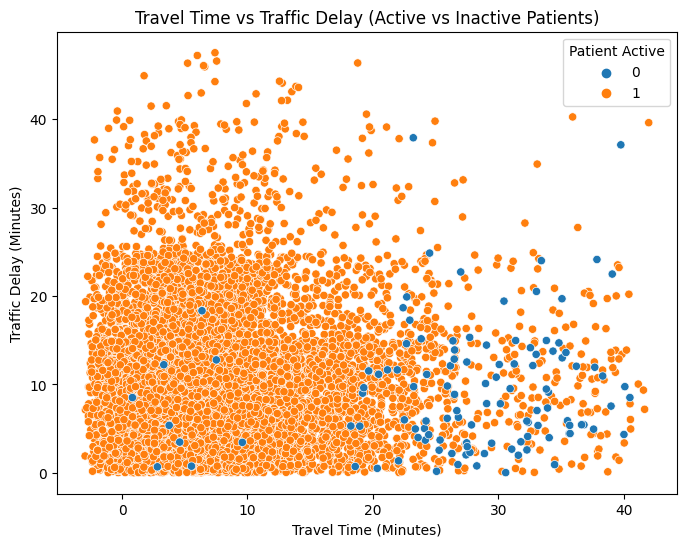

In [36]:
# 1. Distribution of Diagnoses
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, x='Diagnosis', hue='Patient_Active')
plt.title('Distribution of Diagnoses (Active vs Inactive Patients)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.legend(title='Patient Active')
plt.show()

# 2. Distance from Clinic
plt.figure(figsize=(8, 6))
sns.histplot(data=merged_df, x='Distance_From_Clinic', hue='Patient_Active', kde=True)
plt.title('Distribution of Distance from Clinic (Active vs Inactive Patients)')
plt.xlabel('Distance From Clinic (Miles)')
plt.ylabel('Count')
plt.legend(title='Patient Active')
plt.show()

# 3. No-Show Rates by Diagnosis
plt.figure(figsize=(8, 6))
no_show_rates_by_diagnosis = merged_df.groupby('Diagnosis')['No_Show'].mean().reset_index()
sns.barplot(data=no_show_rates_by_diagnosis, x='Diagnosis', y='No_Show')
plt.title('No-Show Rates by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Average No-Show Rate')
plt.ylim(0, 1)
plt.show()

# 4. Inactive vs. Active Patients by Diagnosis and Previous No-Shows
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='Diagnosis', y='Previous_No_Shows', hue='Patient_Active')
plt.title('Previous No-Shows by Diagnosis (Active vs Inactive Patients)')
plt.xlabel('Diagnosis')
plt.ylabel('Previous No-Shows')
plt.legend(title='Patient Active')
plt.show()

# 5. Travel Time vs Traffic Delay
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='Travel_Time', y='Traffic_Delay', hue='Patient_Active')
plt.title('Travel Time vs Traffic Delay (Active vs Inactive Patients)')
plt.xlabel('Travel Time (Minutes)')
plt.ylabel('Traffic Delay (Minutes)')
plt.legend(title='Patient Active')
plt.show()


In [37]:
colors = sns.cubehelix_palette(n_colors=2, light=0.7, dark=0.3).as_hex()

#Distribution of Diagnoses (Active vs Inactive Patients)
diagnosis_distribution_fig = px.histogram(
    merged_df,
    x='Diagnosis',
    color='Patient_Active',
    barmode='group',
    title='Distribution of Diagnoses <br>(Active vs Inactive Patients)',
    labels={'Patient_Active': 'Patient Active'},
    color_discrete_sequence=colors  
)

diagnosis_distribution_fig.update_layout(
    title={'text': 'Distribution of Diagnoses <br>(Active vs Inactive Patients)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    bargap=0.2  
)

diagnosis_distribution_plot = update_figure_layout(diagnosis_distribution_fig)

In [38]:
colors = sns.cubehelix_palette(n_colors=2, light=0.7, dark=0.3).as_hex()

# Distance from Clinic (Active vs Inactive Patients)
distance_from_clinic_fig = px.histogram(
    merged_df,
    x='Distance_From_Clinic',
    color='Patient_Active',
    marginal="violin",  
    title='Distribution of Distance from Clinic <br>(Active vs Inactive Patients)',
    labels={'Distance_From_Clinic': 'Distance From Clinic (Miles)'},
    color_discrete_sequence=colors  
)

distance_from_clinic_fig.update_layout(
    title={'text': 'Distribution of Distance from Clinic <br>(Active vs Inactive Patients)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    bargap=0.2  
)

distance_from_clinic_plot = update_figure_layout(distance_from_clinic_fig)

In [39]:
num_diagnoses = len(no_show_rates_by_diagnosis['Diagnosis'])

colors = sns.cubehelix_palette(n_colors=num_diagnoses, light=0.7, dark=0.3).as_hex()

# No-Show Rates by Diagnosis
no_show_rates_fig = px.bar(
    no_show_rates_by_diagnosis,
    x='Diagnosis',
    y='No_Show',
    title='No-Show Rates by Diagnosis',
    labels={'No_Show': 'Average No-Show Rate'},
    range_y=[0, 1],
    color='Diagnosis',  
    color_discrete_sequence=colors  
)

no_show_rates_fig.update_layout(
    title={'text': 'No-Show Rates by Diagnosis',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    bargap=0.2 
)

no_show_rates_plot = update_figure_layout(no_show_rates_fig)

In [40]:
colors = sns.cubehelix_palette(n_colors=2, light=0.7, dark=0.3).as_hex()

# Previous No-Shows by Diagnosis (Active vs Inactive Patients)
previous_no_shows_fig = px.box(
    merged_df,
    x='Diagnosis',
    y='Previous_No_Shows',
    color='Patient_Active',
    title='Previous No-Shows by Diagnosis <br>(Active vs Inactive Patients)',
    labels={'Previous_No_Shows': 'Previous No-Shows'},
    color_discrete_sequence=colors  
)

previous_no_shows_fig.update_layout(
    title={'text': 'Previous No-Shows by Diagnosis <br>(Active vs Inactive Patients)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}}
)

previous_no_shows_plot = update_figure_layout(previous_no_shows_fig)

In [41]:
# Ensure that Patient_Active is treated as a categorical variable
merged_df['Patient_Active'] = merged_df['Patient_Active'].astype(str)

colors = sns.cubehelix_palette(n_colors=2, light=0.7, dark=0.3).as_hex()

# Travel Time vs Traffic Delay (Active vs Inactive Patients)
travel_time_vs_traffic_delay_fig = px.scatter(
    merged_df,
    x='Travel_Time',
    y='Traffic_Delay',
    color='Patient_Active',  
    title='Travel Time vs Traffic Delay <br>(Active vs Inactive Patients)',
    labels={'Travel_Time': 'Travel Time (Minutes)', 'Traffic_Delay': 'Traffic Delay (Minutes)'},
    color_discrete_sequence=colors  
)

travel_time_vs_traffic_delay_fig.update_layout(
    title={'text': 'Travel Time vs Traffic Delay <br>(Active vs Inactive Patients)',
           'y': 1,
           'x': 0.5,
           'xanchor': 'center',
           'yanchor': 'top',
           'pad': {'b': 10}},
    hovermode='closest' 
)

travel_time_vs_traffic_delay_plot = update_figure_layout(travel_time_vs_traffic_delay_fig)

In [42]:
# Update all figures with the shared Seaborn palette and layout theme
diagnosis_distribution_plot = update_figure_layout(diagnosis_distribution_plot)
distance_from_clinic_plot = update_figure_layout(distance_from_clinic_plot)
no_show_rates_plot = update_figure_layout(no_show_rates_plot)
previous_no_shows_plot = update_figure_layout(previous_no_shows_plot)
travel_time_vs_traffic_delay_plot = update_figure_layout(travel_time_vs_traffic_delay_plot)
no_show_rate_plot = update_figure_layout(no_show_rate_plot)
improvement_gauge_plot = update_figure_layout(improvement_gauge_plot)
reminder_pie_chart_plot = update_figure_layout(reminder_pie_chart_plot)
financial_fig = update_figure_layout(financial_fig)
financial_forecast_fig = update_figure_layout(financial_forecast_fig)
revenue_profit_plot = update_figure_layout(revenue_profit_plot)
revenue_diagnosis_plot = update_figure_layout(revenue_diagnosis_plot)
radar_chart_plot = update_figure_layout(radar_chart_plot)
no_show_age_group_plot = update_figure_layout(no_show_age_group_plot)
revenue_lost_plot = update_figure_layout(revenue_lost_plot)
financial_overview_plot = update_figure_layout(financial_overview_plot)

# Plotly Dash

In [45]:
app = dash.Dash(__name__)

# Function to apply global layout updates (title padding and legend position)
def apply_global_layout(fig):
    fig.update_layout(
        title={
            'y': 1,  # Title at the top
            'x': 0.5,  # Center the title
            'xanchor': 'center',
            'yanchor': 'top',
            'pad': {'t': 15, 'b': 15},  # Padding for the title
        },
        margin={'t': 50, 'b': 60, 'l': 10, 'r': 10},  # Top margin for the title
        autosize=True,  # Ensure the graph resizes to fit
        height=550,  # Set a fixed height for the graph
        legend=dict(
            orientation="h",  # Horizontal legend
            yanchor="bottom",
            y=-0.3,  # Move the legend below the chart
            xanchor="center",
            x=0.5  # Center the legend
        )
    )
    return fig

# Apply global layout settings to all your figures
financial_fig = apply_global_layout(financial_fig)
financial_forecast_fig = apply_global_layout(financial_forecast_fig)
no_show_age_group_plot = apply_global_layout(no_show_age_group_plot)
revenue_lost_plot = apply_global_layout(revenue_lost_plot)
no_show_rate_plot = apply_global_layout(no_show_rate_plot)
improvement_gauge_plot = apply_global_layout(improvement_gauge_plot)
reminder_pie_chart_plot = apply_global_layout(reminder_pie_chart_plot)
diagnosis_distribution_plot = apply_global_layout(diagnosis_distribution_plot)
distance_from_clinic_plot = apply_global_layout(distance_from_clinic_plot)
no_show_rates_plot = apply_global_layout(no_show_rates_plot)
previous_no_shows_plot = apply_global_layout(previous_no_shows_plot)
travel_time_vs_traffic_delay_plot = apply_global_layout(travel_time_vs_traffic_delay_plot)

# Define the layout
app.layout = html.Div(
    style={
        'transform': 'scale(0.80)',  # Adjust this value to scale everything down
        'transform-origin': 'top left',
        'width': 'auto',  # Wider viewport width
        'height': '100vh',  # Full viewport height
        'max-width': '100%',  # No max width limit
        'display': 'grid',
        'grid-template-columns': '1fr 1fr 1fr',  # 3 equal-width columns
        'grid-template-rows': 'min-content min-content min-content min-content',  # Adjust to fit additional sections
        'grid-gap': '20px',  # Space between items
        'padding': '10px',  # Reduce padding around the layout
        'justify-items': 'center',  # Center-aligns everything
        'grid-template-areas': """
            'banner banner banner'
            'section1 section1 section1'
            'box1 box2 box3'
            'section2 section2 section2'
            'box4 box5 box6'
            'section3 section3 section3'
            'box7 box8 box9'
        """  # Layout for sections and graphs
    },
    children=[
        # Banner image in place of the title (occupies the first row)
        html.Div([
            html.Img(src='/assets/transparent400dpiLogoCropped.png', style={'width': '40%', 'height': 'auto'})  # Adjust the image path and style
        ], style={'grid-area': 'banner', 'align-self': 'center'}),  # Aligns banner in grid area 'banner'

        # Financial Section Title
        html.Div([
            html.H2("Financial Overview")
        ], style={
            'grid-area': 'section1',
            'textAlign': 'center',
            'font-family': 'Arial, sans-serif',
            'font-size': '20px',
            'color': '#333',
            'margin-bottom': '10px',  # Reduce margin below section titles
        }),

        # First row of financial graphs
        html.Div([
            dcc.Graph(figure=financial_fig)  # Revenue, profit, costs by quarter
        ], style={'grid-area': 'box1'}),

        html.Div([
            dcc.Graph(figure=financial_forecast_fig)  # Forecast graph
        ], style={'grid-area': 'box2'}),

        html.Div([
            dcc.Graph(figure=revenue_lost_plot)  # Revenue lost by quarter
        ], style={'grid-area': 'box3'}),

        # No-Show Section Title
        html.Div([
            html.H2("No-Show Analysis")
        ], style={
            'grid-area': 'section2',
            'textAlign': 'center',
            'font-family': 'Arial, sans-serif',
            'font-size': '20px',
            'color': '#333',
            'margin-bottom': '10px',  # Reduce margin below section titles
        }),

        # Second row: No-Show related graphs
        html.Div([
            dcc.Graph(figure=no_show_age_group_plot)  # No-show rate by age group
        ], style={'grid-area': 'box4'}),

        html.Div([
            dcc.Graph(figure=no_show_rate_plot)  # Comparison of no-show rates
        ], style={'grid-area': 'box5'}),

        html.Div([
            dcc.Graph(figure=improvement_gauge_plot)  # No-show improvement gauge
        ], style={'grid-area': 'box6'}),

        # Patient Churn Section Title
        html.Div([
            html.H2("Patient Churn Analysis")
        ], style={
            'grid-area': 'section3',
            'textAlign': 'center',
            'font-family': 'Arial, sans-serif',
            'font-size': '20px',
            'color': '#333',
            'margin-bottom': '10px',  # Reduce margin below section titles
        }),

        # Third row: Patient Churn related graphs
        html.Div([
            dcc.Graph(figure=diagnosis_distribution_plot)  # Distribution of diagnoses
        ], style={'grid-area': 'box7'}),

        html.Div([
            dcc.Graph(figure=distance_from_clinic_plot)  # Distance from clinic
        ], style={'grid-area': 'box8'}),

        html.Div([
            dcc.Graph(figure=previous_no_shows_plot)  # Previous no-shows by diagnosis
        ], style={'grid-area': 'box9'})
    ]
)


#if __name__ == '__main__':
#    app.run_server(host="0.0.0.0", port=8080, debug=False)

# Run the app on a local server
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)
